# Predicting LessThanMaximumTotal from n and bridges

This notebook fits a skewed bell-shaped parametric formula for LessThanMaximumTotal as a function of n and bridges.

We prioritize avoiding underprediction (serious error) over overprediction (minor error) by training with high-quantile regression and evaluating with an asymmetric error metric.

In [ ]:
from __future__ import annotations

from datetime import datetime
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from textwrap import dedent
from typing import Any
import json
import matplotlib.pyplot as pyplot
import numpy
import pandas
import re
import seaborn

# Resolve reference directory and dataset path robustly
def resolve_reference_dir() -> Path:
    candidates: list[Path] = []
    # Try notebook file location when available
    try:
        this_path = Path(__file__).resolve()
        candidates.append(this_path.parent)
        # If the notebook sits under mapFolding/reference, parent is already correct
        # Add project-root derived guess as well
        candidates.append(this_path.parent)
    except NameError:
        pass
    cwd = Path.cwd()
    candidates.extend([
        cwd / 'mapFolding' / 'reference',
        cwd / 'reference',
        Path('c:/apps/mapFolding/mapFolding/reference'),  # last-resort fallback
    ])
    for p in candidates:
        if p.exists():
            return p
    return cwd

def choose_data_csv(reference_dir: Path) -> Path:
    csvs = list(reference_dir.glob('A005316.csv'))
    if not csvs:
        # Fallback to historical default if nothing matches the pattern
        return reference_dir / 'A000682_28_39.csv'
    def end_range(path: Path) -> tuple[int, int]:
        m = re.search(r'A000682_(\d+)_([0-9]+)\.csv$', path.name)
        if m:
            return int(m.group(1)), int(m.group(2))
        return (0, -1)
    # Prefer the file with the largest upper n-range
    csvs.sort(key=lambda p: end_range(p)[1])
    return csvs[-1]

ref_dir = resolve_reference_dir()
data_path = choose_data_csv(ref_dir)
print({'ref_dir': str(ref_dir), 'data_path': str(data_path), 'data_path_exists': data_path.exists()})

## Load Data

In [2]:
# Section 2: Load Data

dtypes: dict[str, str] = {
    'n': 'int64',
    'bridges': 'int64',
    'LessThanMaximumTotal': 'int64',
}

df = pandas.read_csv(data_path, dtype=dtypes) # pyright: ignore[reportArgumentType]

# Replace brittle range asserts with robust, data-driven validations
assert (df['n'] >= 1).all(), 'n must be >= 1'
assert (df['bridges'] >= 0).all(), 'bridges must be >= 0'
# In domain, bridges cannot exceed n; clip for safety and warn if any were out-of-domain
violations = (df['bridges'] > df['n']).sum()
if violations:
    print(f'Warning: {violations} rows had bridges>n; values will be clipped for feature building.')

print({
    'n_min': int(df['n'].min()),
    'n_max': int(df['n'].max()),
    'bridges_min': int(df['bridges'].min()),
    'bridges_max': int(df['bridges'].max()),
})

print(df.describe(include='all'))
print('Rows:', len(df), 'unique n:', sorted(df.n.unique()))

{'n_min': 2, 'n_max': 45, 'bridges_min': 1, 'bridges_max': 44}
                n     bridges  LessThanMaximumTotal
count  966.000000  966.000000          9.660000e+02
mean    30.316770   15.490683          4.075683e+06
std     10.376491   10.523471          2.131671e+07
min      2.000000    1.000000          1.000000e+00
25%     23.000000    7.000000          4.000000e+01
50%     32.000000   14.000000          9.740000e+02
75%     39.000000   23.000000          4.618100e+04
max     45.000000   44.000000          2.580907e+08
Rows: 966 unique n: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64

## Feature Engineering (fractional bridges, transforms)

In [3]:
# Section 3: Feature Engineering
# Runtime clipping utility

def clip_bridges(bridges_val: float, n_val: float) -> float:
    if n_val <= 0:
        return 0.0
    return float(max(0.0, min(bridges_val, n_val)))

# Original, no clipping yet (analysis on provided data)
df = df.copy()
df['x'] = df['bridges'] / df['n']
df['x2'] = df['x'] ** 2
df['x3'] = df['x'] ** 3
df['nx'] = df['n'] * df['x']
df['nx2'] = df['n'] * df['x2']

# Log1p transform of target (heavy-tailed)
df['z'] = numpy.log1p(df['LessThanMaximumTotal'].astype('float64'))

df.head()

,n,bridges,LessThanMaximumTotal,x,x2,x3,nx,nx2,z
0,2,1,1,0.500000,0.250000,0.125000,1.0,0.500000,0.693147
1,3,2,3,0.666667,0.444444,0.296296,2.0,1.333333,1.386294
2,3,1,2,0.333333,0.111111,0.037037,1.0,0.333333,1.098612
3,4,3,2,0.750000,0.562500,0.421875,3.0,2.250000,1.098612
4,4,2,4,0.500000,0.250000,0.125000,2.0,1.000000,1.609438


## Visualize Target vs n and bridges (2D/3D, per-n curves)

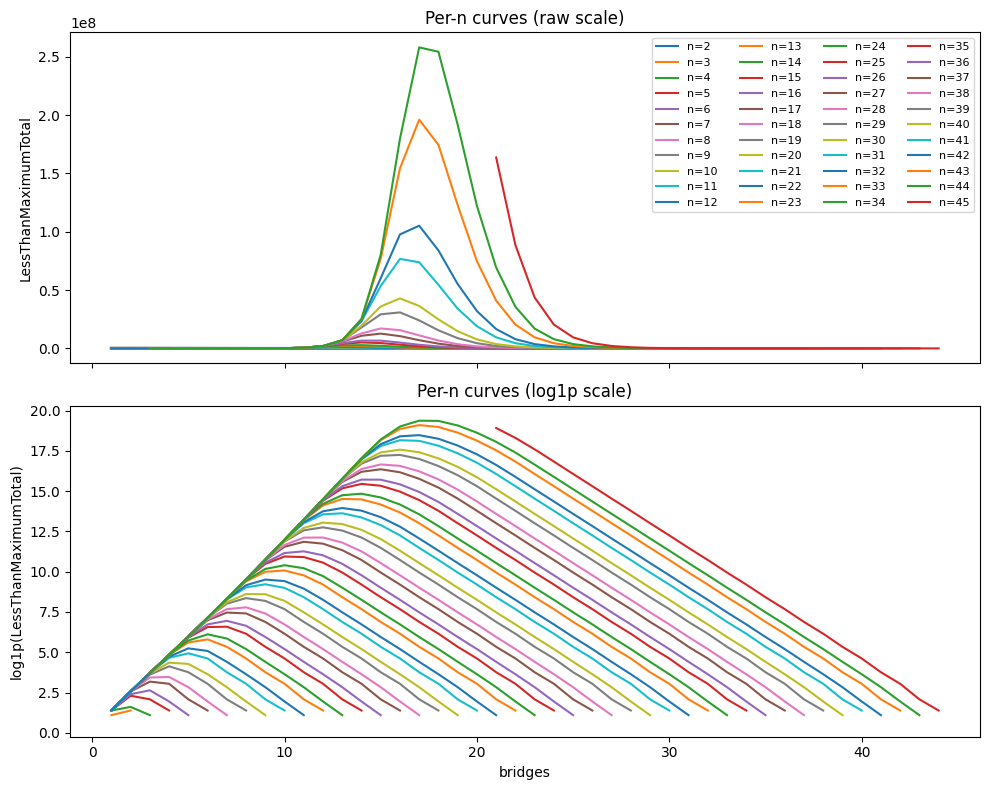

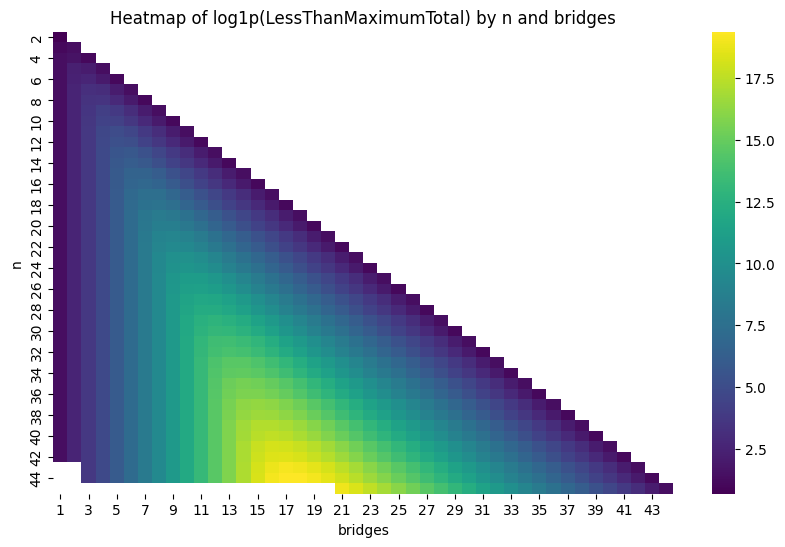

: 

In [ ]:
# pyright: basic

# Per-n curves of y vs bridges (and log scale)
fig, axes = pyplot.subplots(2, 1, figsize=(10, 8), sharex=True)
for n_val, df_n in df.groupby('n'):
    axes[0].plot(df_n['bridges'], df_n['LessThanMaximumTotal'], label=f"n={n_val}")
    axes[1].plot(df_n['bridges'], numpy.log1p(df_n['LessThanMaximumTotal']), label=f"n={n_val}")
axes[0].set_ylabel('LessThanMaximumTotal')
axes[1].set_ylabel('log1p(LessThanMaximumTotal)')
axes[1].set_xlabel('bridges')
axes[0].set_title('Per-n curves (raw scale)')
axes[1].set_title('Per-n curves (log1p scale)')
axes[0].legend(ncol=4, fontsize=8)
pyplot.tight_layout()
pyplot.show()

# Heatmap of mean log1p(y) over (n, bridges)
pivot = df.pivot_table(index='n', columns='bridges', values='z', aggfunc='mean')
pyplot.figure(figsize=(10, 6))
seaborn.heatmap(pivot, cmap='viridis')
pyplot.title('Heatmap of log1p(LessThanMaximumTotal) by n and bridges')
pyplot.xlabel('bridges')
pyplot.ylabel('n')
pyplot.show()

## Define Parametric Formula Candidates
Feature builders for varying polynomial degree in x and interactions with n

In [ ]:
# pyright: basic

def build_features(n_array: pandas.Series, bridges_array: pandas.Series, degree:int=3):
    n_array = numpy.asarray(n_array, dtype='float64') # pyright: ignore[reportAssignmentType]
    bridges_array = numpy.asarray(bridges_array, dtype='float64') # pyright: ignore[reportAssignmentType]
    bridges_array = numpy.clip(bridges_array, 0.0, None) # pyright: ignore[reportCallIssue, reportArgumentType]
    bridges_array = numpy.minimum(bridges_array, n_array) # pyright: ignore[reportArgumentType, reportCallIssue]
    x = numpy.divide(bridges_array, n_array, out=numpy.zeros_like(bridges_array), where=n_array>0) # pyright: ignore[reportArgumentType, reportCallIssue]
    # Base terms up to degree on x
    columns: list[pandas.Series] = []
    feature_names: list[str] = []
    columns.append(n_array) ; feature_names.append('n')
    columns.append(n_array**2) ; feature_names.append('n2')
    # x, x^2, x^3, ... up to degree
    x_powers = [x**p for p in range(1, degree+1)]
    for p, xp in enumerate(x_powers, start=1):
        columns.append(xp) ; feature_names.append(f'x{p}')
    # interactions n*x^k up to degree-1 for stability
    for p, xp in enumerate(x_powers[:max(0, degree-1)], start=1):
        columns.append(n_array * xp) ; feature_names.append(f'nx{p}')
    X = numpy.column_stack(columns) # pyright: ignore[reportArgumentType, reportCallIssue]
    return X, feature_names

# Prepare base matrices for degree exploration
X_deg3, feature_names_deg3 = build_features(df['n'], df['bridges'], degree=3)
X_deg4, feature_names_deg4 = build_features(df['n'], df['bridges'], degree=4)
X_deg2, feature_names_deg2 = build_features(df['n'], df['bridges'], degree=2)

y = df['LessThanMaximumTotal'].to_numpy(dtype='float64')
z = df['z'].to_numpy(dtype='float64')

print('deg2 features:', feature_names_deg2)
print('deg3 features:', feature_names_deg3)
print('deg4 features:', feature_names_deg4)

## Train Quantile Regression (asymmetric loss; log-target)

In [ ]:
# Section 6: Quantile Regression setup

quantiles = [0.7, 0.8, 0.9]
alphas = [0.0, 1e-6, 1e-4, 1e-3, 1e-2]

# Utility to back-transform

def z_to_y(z_hat: numpy.ndarray) -> numpy.ndarray:
    return numpy.expm1(z_hat)

# Asymmetric weighted MAPE-like metric on original scale

def weighted_mape(y_true: numpy.ndarray, y_pred: numpy.ndarray, under_weight: float = 29.0):
    y_true = y_true.astype('float64')
    y_pred = y_pred.astype('float64')
    denom = numpy.maximum(1.0, y_true)  # avoid division by zero and over-penalizing tiny values
    diff = y_pred - y_true
    weights = numpy.where(diff < 0, under_weight, 1.0)
    return numpy.mean(weights * numpy.abs(diff) / denom)

# Feature registry
feature_sets: dict[int, tuple[numpy.ndarray, list[str]]] = {
    2: (X_deg2, feature_names_deg2),
    3: (X_deg3, feature_names_deg3),
    4: (X_deg4, feature_names_deg4),
}

## Hyperparameter Search (degree, regularization, quantile)

In [ ]:
logo = LeaveOneGroupOut()

results: list[dict[str, Any]] = []

groups = df['n'].to_numpy()

for degree, (X, feature_names) in feature_sets.items():
    for tau in quantiles:
        for alpha in alphas:
            cv_errors: list[numpy.floating[Any]] = []
            for train_idx, test_idx in logo.split(X, z, groups=groups): # pyright: ignore[reportUnknownVariableType,reportUnknownMemberType]
                model = QuantileRegressor(quantile=tau, alpha=alpha, solver='highs')
                model.fit(X[train_idx], z[train_idx])
                z_hat = model.predict(X[test_idx])
                y_hat = z_to_y(z_hat)
                cv_errors.append(weighted_mape(y[test_idx], y_hat))
            mean_err = float(numpy.mean(cv_errors))
            p90_err = float(numpy.percentile(cv_errors, 90))
            results.append({
                'degree': degree,
                'tau': tau,
                'alpha': alpha,
                'mean_err': mean_err,
                'p90_err': p90_err,
                'features': feature_names,
            })

results_df = pandas.DataFrame(results).sort_values(['mean_err','p90_err']).reset_index(drop=True)
results_df.head(10)

## Evaluation with Asymmetric Error Metric (holdout by n)

In [ ]:
# Section 8: Evaluate best config on CV folds and inspect errors
best_row = results_df.iloc[0]
print('Best config:', best_row.to_dict())

best_degree = int(best_row['degree'])
best_tau = float(best_row['tau'])
best_alpha = float(best_row['alpha'])
X_best, feature_names_best = feature_sets[best_degree]

fold_errors: list[numpy.floating[Any]] = []
for train_idx, test_idx in logo.split(X_best, z, groups=groups): # pyright: ignore[reportUnknownMemberType,reportUnknownVariableType]
    model = QuantileRegressor(quantile=best_tau, alpha=best_alpha, solver='highs')
    model.fit(X_best[train_idx], z[train_idx])
    z_hat = model.predict(X_best[test_idx])
    y_hat = z_to_y(z_hat)
    err = weighted_mape(y[test_idx], y_hat)
    fold_errors.append(err)

print('Fold errors:', fold_errors)
print('Mean:', float(numpy.mean(fold_errors)), 'P90:', float(numpy.percentile(fold_errors, 90)))

## Final Coefficients and Python Prediction Function

In [ ]:
# Section 9: Fit final model on full data and emit function
best_model = QuantileRegressor(quantile=best_tau, alpha=best_alpha, solver='highs')
best_model.fit(X_best, z)

intercept = float(best_model.intercept_)
coefs = best_model.coef_.astype('float64')

print('Intercept:', intercept)
print('Coefficients in order:', feature_names_best)
print(coefs)

# Ready-to-paste Python function with constants inlined

feature_order = feature_names_best

# Precompute maximum x power needed
max_x_power = 0
for name in feature_order:
    if name.startswith('x') and name[1:].isdigit():
        max_x_power = max(max_x_power, int(name[1:]))


In [ ]:

lines: list[str] = []
lines.append('from math import exp')
lines.append('')
lines.append('def predict_less_than_max(indexTransferMatrix: int) -> float:')
lines.append('    n = float(_n)')
lines.append('    b = max(0.0, min(float(indexTransferMatrix), n))')
lines.append('    x = b / n')
# x powers
for p in range(1, max_x_power+1):
    if p == 1:
        lines.append('    x1 = x')
    else:
        lines.append(f'    x{p} = x**{p}')
# Build vals per feature_order
lines.append('    vals: list[float] = []')
for name in feature_order:
    if name == 'n':
        lines.append('    vals.append(n)  # n')
    elif name == 'n2':
        lines.append('    vals.append(n**2)  # n2')
    elif name.startswith('x') and name[1:].isdigit():
        p = int(name[1:])
        lines.append(f'    vals.append(x{p})  # {name}')
    elif name.startswith('nx') and name[2:].isdigit():
        p = int(name[2:])
        lines.append(f'    vals.append(n * x{p})  # {name}')
    else:
        lines.append(f'    # Unknown feature name {name}, treat as 0')
        lines.append('    vals.append(0.0)')
# Linear form and back-transform
lines.append(f"    z_hat = {intercept:.12g}")
for i, w in enumerate(coefs):
    lines.append(f"    z_hat += ({w:.12g}) * vals[{i}]")
lines.append('    y_hat = exp(z_hat) - 1.0')
lines.append('    return max(y_hat, 0.0)')

function_text = dedent('\n'.join(lines))
print(function_text)

## Export Coefficients and Function Snippet

In [ ]:
# Section 10: Export coefficients and function snippet

artifacts: dict[str, Any] = {
    'best_degree': best_degree,
    'best_tau': best_tau,
    'best_alpha': best_alpha,
    'feature_order': feature_names_best,
    'intercept': intercept,
    'coefficients': coefs.tolist(),
}

json_path = ref_dir / 'LessThanMaximumTotal_parametric_model.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(artifacts, f, indent=2)

print('Saved coefficients to', json_path)

## Nonlinear Benchmark (Gradient Boosting with quantile loss)

In [ ]:
# Section 11: GradientBoosting quantile benchmark

best_bench: dict[str, Any] | None = None
bench_results: list[dict[str, float]] = []

param_grid: list[dict[str, float]] = [
    {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05},
    {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.05},
    {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05},
]

X_bench = X_best  # reuse same features
kfold = GroupKFold(n_splits=len(df['n'].unique()))

tau_bench = best_tau  # use same quantile

for params in param_grid:
    fold_errs: list[numpy.floating[Any]] = []
    for train_idx, test_idx in kfold.split(X_bench, z, groups=groups):
        gbr = GradientBoostingRegressor(loss='quantile', alpha=tau_bench, **params) # pyright: ignore[reportArgumentType]
        gbr.fit(X_bench[train_idx], z[train_idx]) # pyright: ignore[reportUnknownMemberType]
        z_hat = gbr.predict(X_bench[test_idx])
        y_hat = z_to_y(z_hat)
        fold_errs.append(weighted_mape(y[test_idx], y_hat))
    mean_err = float(numpy.mean(fold_errs))
    bench_results.append({'params': params, 'mean_err': mean_err}) # pyright: ignore[reportArgumentType]
    if best_bench is None or mean_err < best_bench['mean_err']:
        best_bench = {'params': params, 'mean_err': mean_err}

print('Best benchmark:', best_bench)
bench_results

## Benchmark vs Parametric Formula Comparison

In [ ]:
# pyright: basic
param_mean = float(results_df.iloc[0]['mean_err'])
bench_mean: float | None = best_bench['mean_err'] if best_bench else None
print({'parametric_mean_err': param_mean, 'benchmark_mean_err': bench_mean})

# Plot per-n curves predicted by parametric model vs observed (on log scale)

# Fit best parametric on full data (already fit)
z_hat_all = best_model.predict(X_best)

df_plot = df.copy()
df_plot['z_hat_param'] = z_hat_all

grouped = df_plot.groupby('n')
fig, ax = pyplot.subplots(figsize=(10,6))
for n_val, g in grouped:
    ax.plot(g['bridges'], g['z'], 'o-', label=f'obs n={n_val}', alpha=0.4)
    ax.plot(g['bridges'], g['z_hat_param'], 'x--', label=f'param n={n_val}', alpha=0.7)
ax.set_xlabel('bridges')
ax.set_ylabel('log1p(y)')
ax.set_title('Observed vs Parametric Predicted (log scale)')
ax.legend(ncol=3, fontsize=7)
pyplot.tight_layout()
pyplot.show()

## Save Artifacts (figures, metrics, model JSON)

In [ ]:
# Section 13: Save artifacts

metrics: dict[str, Any] = {
    'timestamp': datetime.now().isoformat() + 'Z',
    'parametric_best': best_row.to_dict(),
    'parametric_cv_mean_err': float(results_df.iloc[0]['mean_err']),
    'benchmark_best': best_bench,
}

metrics_path = ref_dir / 'LessThanMaximumTotal_model_metrics.json'
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=2)
print('Saved metrics to', metrics_path)

# Save last figure (if any) as PNG
fig_path = ref_dir / 'LessThanMaximumTotal_obs_vs_param.png'
try:
    pyplot.gcf().savefig(fig_path, dpi=160) # pyright: ignore[reportUnknownMemberType]
    print('Saved figure to', fig_path)
except Exception as e:
    print('Figure save skipped:', e)